# **Detecting COVID-19 in CT scan images**

**Date created:** 28/05/2021                                                
**Githup link:** https://github.com/taleb-hub/Detecting-COVID-19-in-CT-images

# **Introduction:**                                                        
COVID-19 is a disease primarily affects lungs. In this project I present a model for detecting COVID-19 infection in Computed Tomography images (CT) by using deep learning algorithms.      
  



#**Data Description:**                                                      
In this project I use a dataset containing **1252** CT scans that are **positive** for SARS-CoV-2 infection (COVID-19) and **1230** CT scans for patients **non-infected** by SARS-CoV-2, **2482** CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil.      
##**Reference:**                                                            
A large dataset of real patients CT scans for SARS-CoV-2 identification." medRxiv (2020). doi: https://doi.org/10.1101/2020.04.24.20078584.               
The CT scans dataset : [link](https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset)




# **Import the necessary libraries:**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from cv2 import imread
import os
from os import listdir
import zipfile
from google.colab import files

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model,Sequential, Input, load_model
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline


# **Loading data and preprocessing:**


*   Split the data into two sets the train and validation datasets

**Training set:** 1984 images in total                                         
**Validation set:** 497 images in total                                        


*   Preprocessing the images






In [2]:
# connect google colab with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Unzip the data file and extract all the data to 'tmp' file**

In [3]:
# specifying the zip file name
data_zipfile = '/content/drive/MyDrive/tmp.zip' 

# opening the zip file in READ mode
zip_ref = zipfile.ZipFile(data_zipfile, 'r')

# extracting all the files 
zip_ref.extractall('/content/drive/MyDrive/tmp')
zip_ref.close()

In [6]:
# train set includes 2481 image : 1252 Covid and 1229 nonCovid
train_dir='/content/drive/MyDrive/tmp/tmp'

tr_Covid = '/content/drive/MyDrive/tmp/tmp/COVID'
tr_nonCovid = '/content/drive/MyDrive/tmp/tmp/non-COVID'
print(len(os.listdir(tr_Covid)))
print(len(os.listdir(tr_nonCovid)))


1252
1229


In [7]:
disease_types=['COVID', 'non-COVID']
train_data = []
for disease_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), disease_id, sp])

In [8]:
# take a look on the dataset as a dataframe
# see that:ID = 0 --> Covid  vs ID = 1 --> non Covid
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(-10)

,File,DiseaseID,Disease Type
0,COVID/Covid (1077).png,0,COVID
1,COVID/Covid (1068).png,0,COVID
2,COVID/Covid (1069).png,0,COVID
3,COVID/Covid (1063).png,0,COVID
4,COVID/Covid (1062).png,0,COVID
...,...,...,...
2466,non-COVID/Non-Covid (604).png,1,non-COVID
2467,non-COVID/Non-Covid (467).png,1,non-COVID
2468,non-COVID/Non-Covid (609).png,1,non-COVID
2469,non-COVID/Non-Covid (608).png,1,non-COVID


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   File          2481 non-null   object
 1   DiseaseID     2481 non-null   int64 
 2   Disease Type  2481 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.3+ KB


In [10]:
train.shape

(2481, 3)

In [11]:
len(train)

2481

#**Show some images from the datasets:**

In [12]:
def plot_defects(case_type, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    defect_files = train['File'][train['Disease Type'] == case_type].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(train_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 15

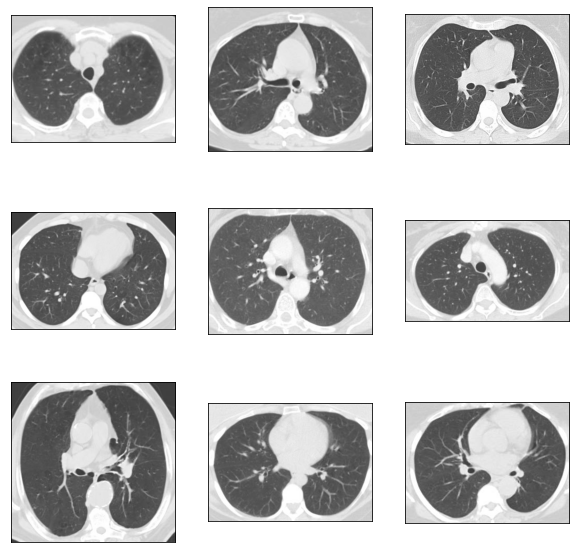

In [ ]:
plot_defects('non-COVID', 3,3)

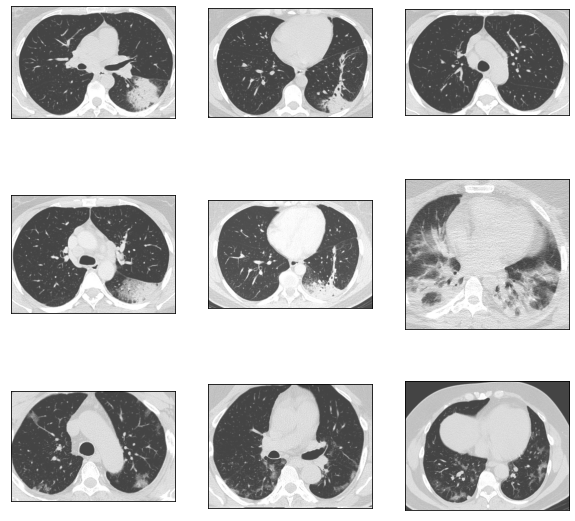

In [ ]:
plot_defects('COVID', 3, 3)

**Preprocessing the imges:**

In [13]:
IMAGE_SIZE = 224
# Loading a color image is the default flag
def read_image(filepath):
    return cv2.imread(os.path.join(train_dir, filepath)) 
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)

In [14]:
# change the images' shapes to fit the input shape layer of the VGG16 model 
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:14, 169.10it/s]


Train Shape: (2481, 224, 224, 3)


In [15]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2481, 2)


In [16]:
Y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [17]:
Y_train.shape

(2481, 2)

##**Split the dataset into train and validation sets:**

In [18]:
# split the dataset
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

In [19]:
X_train.shape

(1984, 224, 224, 3)

In [20]:
Y_train.shape

(1984, 2)

In [21]:
X_val.shape

(497, 224, 224, 3)

In [22]:
Y_val.shape

(497, 2)

#**Architecture of VGG16:**    
VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”.            
For more details about the VGG16 model: [link](https://neurohive.io/en/popular-networks/vgg16/)      
###Reference: https://arxiv.org/abs/1409.1556
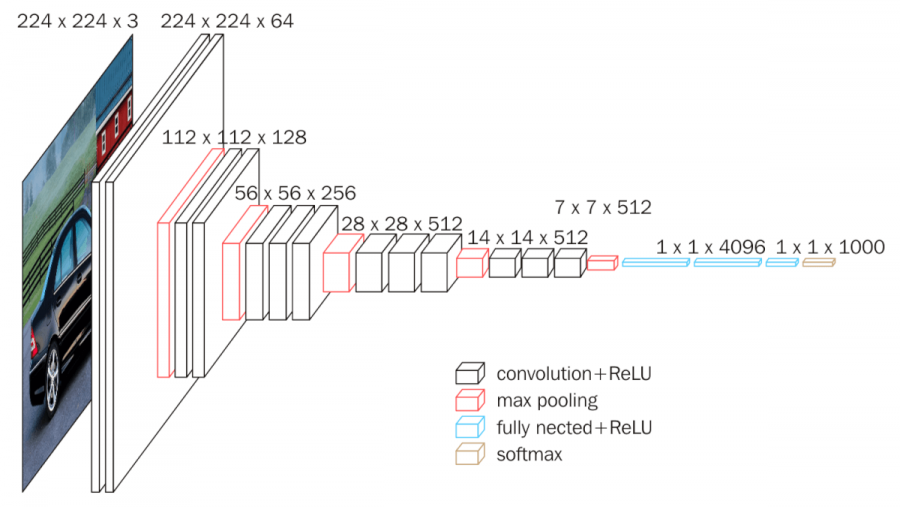



#**Import the VGG16 model:**                                                

In [23]:
# load the model
vgg = VGG16(weights='imagenet', include_top= False, input_shape=(224,224,3))
# summarize the VGG16 model
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

#**Build the model:**

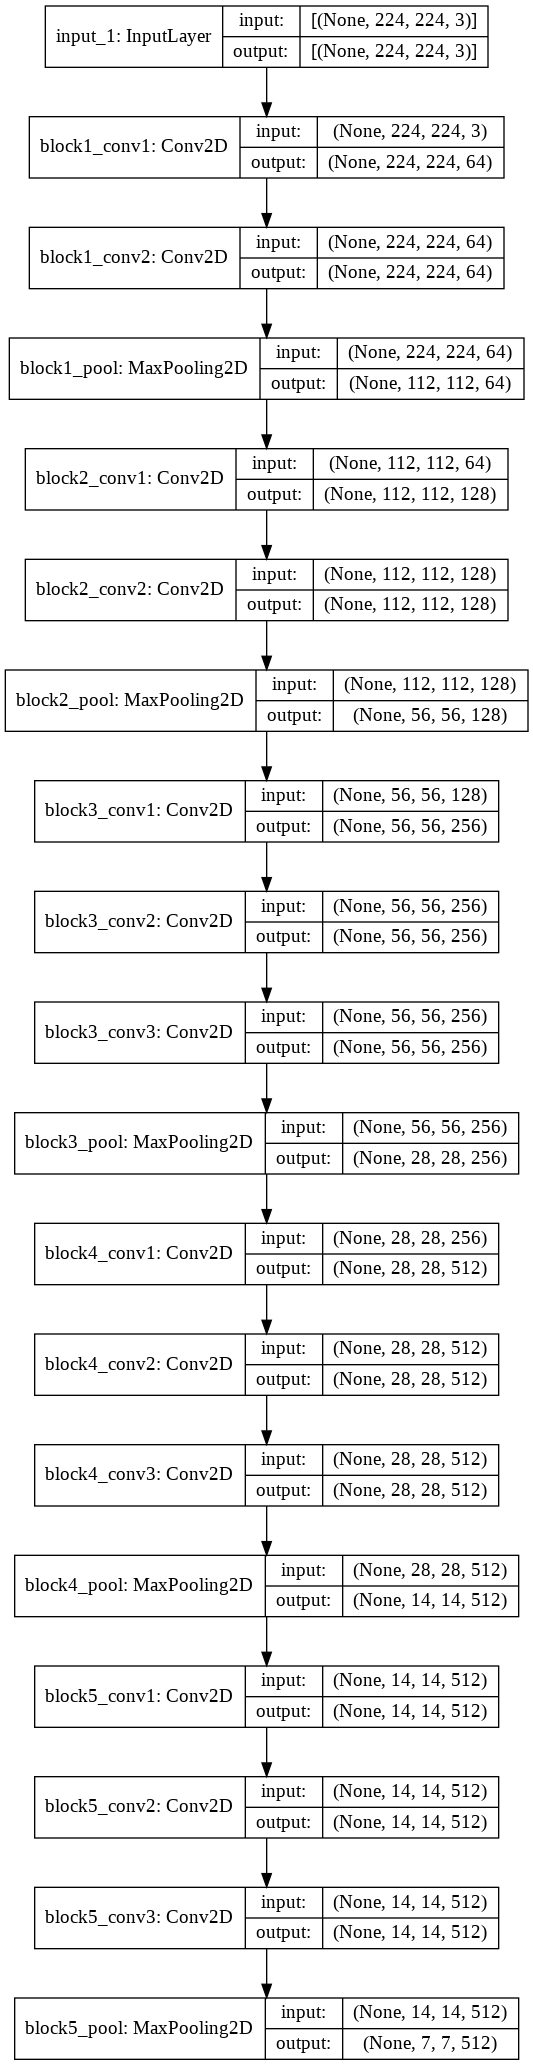

In [ ]:
plot_model(vgg, show_shapes=True, show_layer_names=True)

In [24]:
# the sequential model in keras
model = Sequential()
model.add(vgg)

# adding flatten layer to flatten all the output into a single dim array
model.add(Flatten())

# adding Droupout layer to avoid the overfitting
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))

# this my output layer with two neurons
model.add(Dense(2, activation='sigmoid'))

# summarize the model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________


#**Data augmentation**

In [25]:
batch_size = 64
epoch = 50

train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                   vertical_flip=True)
train_datagen.fit(X_train)



In [ ]:
# # Fit the model on the batches generated by datagen.flow().
# model.fit_generator(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
#                     steps_per_epoch=X_train.shape[0] // batch_size, epochs=epoch,
#                     validation_data=(X_val, Y_val))

#**Training:**

In [27]:
epoch = 50
# learning rate by default in adam optimizer in keras is lr = .001
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train,Y_train, epochs=epoch, batch_size=64, validation_data=(X_val, Y_val))

Epoch 1/50
31/31 [==============================] - 97s 1s/step - loss: 9.4477 - acc: 0.5069 - val_loss: 0.6921 - val_acc: 0.5252
Epoch 2/50
31/31 [==============================] - 27s 859ms/step - loss: 0.7145 - acc: 0.5296 - val_loss: 0.6199 - val_acc: 0.6821
Epoch 3/50
31/31 [==============================] - 26s 834ms/step - loss: 0.6808 - acc: 0.5623 - val_loss: 0.6830 - val_acc: 0.6318
Epoch 4/50
31/31 [==============================] - 26s 835ms/step - loss: 0.6790 - acc: 0.5865 - val_loss: 0.6608 - val_acc: 0.5372
Epoch 5/50
31/31 [==============================] - 26s 842ms/step - loss: 0.6620 - acc: 0.6047 - val_loss: 0.5320 - val_acc: 0.7666
Epoch 6/50
31/31 [==============================] - 26s 840ms/step - loss: 0.5723 - acc: 0.6920 - val_loss: 0.5456 - val_acc: 0.7223
Epoch 7/50
31/31 [==============================] - 26s 840ms/step - loss: 0.5482 - acc: 0.7261 - val_loss: 0.4775 - val_acc: 0.8109
Epoch 8/50
31/31 [==============================] - 26s 844ms/step - los

In [28]:
# save the model
model.save('vgg.h5')
print('The model is saved!')

The model is saved!


# **Visualizing model performance:**                                        
Here the model accuracy and loss for the training and the validation sets are printed.

In [29]:
score, test_acc = model.evaluate(X_val, Y_val)
print('\nTest score:', score)
print('\nTest accuracy:', test_acc)

16/16 [==============================] - 12s 372ms/step - loss: 0.1778 - acc: 0.9477

Test score: 0.17782457172870636

Test accuracy: 0.9476861357688904


#**Evaluate the model performance:**                                        
Here the model accuracy and loss for the training and the validation sets are ploted.

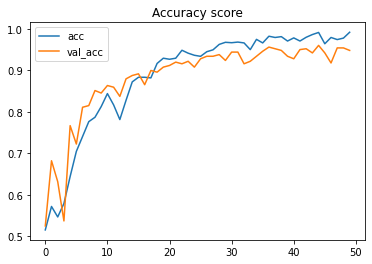

In [30]:
# plot the Accuracy score
plt.title('Accuracy score')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

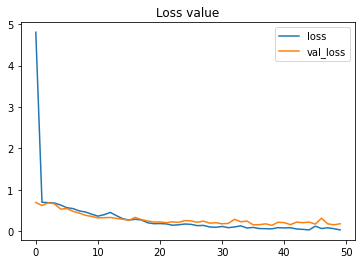

In [31]:
# plot the Loss value
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#**Make perdictions on a single CT image:**                                 
Detreminging wether the uploded image a **Pos.** case or **Neg.** case of COVID-19

Saving Covid (1252).png to Covid (1252) (1).png
[1.0000000e+00 1.4598461e-21]


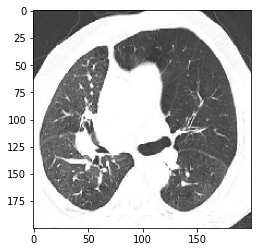

Prediction: Covid-19


In [34]:
from skimage import io
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, grayscale=False, target_size=(224, 224))
  show_img=image.load_img(path, grayscale=False, target_size=(200, 200))
  disease_class=['Covid-19','Non Covid-19']
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x/= 255
  custom = model.predict(x)
  print(custom[0])
  plt.imshow(show_img)
  plt.show()
  a=custom[0]
  ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

Saving Covid (1252).png to Covid (1252) (2).png
[1.0000000e+00 1.4598461e-21]


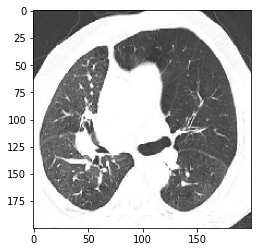

Prediction: Covid-19


In [37]:
from skimage import io
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, grayscale=False, target_size=(224, 224))
  show_img=image.load_img(path, grayscale=False, target_size=(200, 200))
  disease_class=['Covid-19','Non Covid-19']
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x/= 255
  custom = model.predict(x)
  print(custom[0])
  plt.imshow(show_img)
  plt.show()
  a=custom[0]
  ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

Saving Non-Covid (1228).png to Non-Covid (1228) (3).png
[1.000000e+00 1.462276e-21]


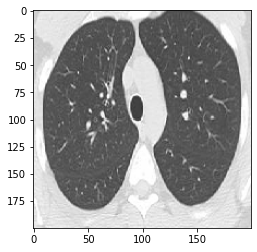

Prediction: Covid-19


In [38]:
from skimage import io
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, grayscale=False, target_size=(224, 224))
  show_img=image.load_img(path, grayscale=False, target_size=(200, 200))
  disease_class=['Covid-19','Non Covid-19']
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x/= 255
  custom = model.predict(x)
  print(custom[0])
  plt.imshow(show_img)
  plt.show()
  a=custom[0]
  ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])